# word2vec_basic

In [1]:
import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### step1 读取数据

In [2]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with open(filename,'rb') as f:
        data=[]
        for line in f:
            col=line.decode().strip()
            for word in col:
                data.append(word)
    return data

filename='QuanSongCi.txt'
vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 1786003


### step2 创建字典并将稀有数据用unk表示

In [3]:
vocabulary_size = 5000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    #取词频最高的前50000个汉字加入到count中 值表示出现的次数
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    #按count顺序创建字典，key是字 value是顺序
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    #返回各个word在dictionary中的索引，如果不在dictionary的话就将其置为0，通过这样可以得到unk的个数
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    #重置unk的个数
    count[0][1] = unk_count
    #反转一下字典，索引在前，word在后
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
#del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0


Most common words (+UNK) [['UNK', 1194], ('。', 149620), ('，', 108451), ('、', 19612), ('人', 13607)]
Sample data [1502, 1827, 39, 612, 46, 8, 110, 116, 7, 9] ['潘', '阆', '酒', '泉', '子', '（', '十', '之', '一', '）']


### step3 生成训练的batch  skip-gram model

In [4]:
def generate_batch(batch_size, num_skips, skip_window):
    #skip_window 表示从当前输入词的一端（左边或右边）选取词的数量
    #num_skips 它代表着我们从整个窗口中选取多少个不同的词作为我们的output word
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)#生成一个空的batch
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)#空的label
    span = 2 * skip_window + 1  # 扫描的窗口，输入词加其前后的skip_window
    buffer = collections.deque(maxlen=span)  # 一个跟span等大的空的deque
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])#从data_index到span的长度填入buffer中
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

#测试用的
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],reverse_dictionary[labels[i, 0]])

1827 阆 -> 1502 潘
1827 阆 -> 39 酒
39 酒 -> 1827 阆
39 酒 -> 612 泉
612 泉 -> 39 酒
612 泉 -> 46 子
46 子 -> 612 泉
46 子 -> 8 （


### step4 创建并且训练模型

In [5]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)#通过lookup方式迅速计算输入和权重的计算

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
#saver = tf.train.Saver()

### step5 开始训练

In [6]:
num_steps = 400000

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  196.6733856201172
Nearest to 水: 鸽, 车, 翅, 尸, 慑, 赫, 归, 傅,
Nearest to 自: 画, 坠, 澒, 融, 渴, 贞, 簪, 脐,
Nearest to UNK: 庄, 姮, t, 滔, 娶, 斟, 羁, 镝,
Nearest to 月: 迁, 童, 但, 蹒, 爨, 畸, 漉, 霈,
Nearest to 梅: 肇, 闾, 浴, 股, 榷, 衱, 祝, 轩,
Nearest to 楼: 瓞, 拱, 抆, 螃, 翁, 汉, 节, 擎,
Nearest to 又: 腮, 诬, 捏, 粲, 亢, 蓼, 朦, 厢,
Nearest to 似: 况, 鸯, 汉, 颔, 胃, 徐, 横, 衫,
Nearest to 、: 枇, 佗, 希, 畀, 雀, 莳, 普, 撼,
Nearest to 更: 面, 低, 萤, 澧, 矗, 蘸, 榄, 湖,
Nearest to 为: 付, 蒨, 苕, 郊, 伪, 筮, 缲, 卜,
Nearest to 明: 筵, 戈, 珞, 彭, 妻, 赛, 椒, 霏,
Nearest to 烟: 凰, 朔, 雠, 椽, , 续, 毁, 擫,
Nearest to 年: 呵, 迂, F, 莺, 愫, 棚, 鲜, 账,
Nearest to 深: 茎, 释, 杰, 汾, 亮, 做, 姮, 渌,
Nearest to 尽: 翳, 粟, 摺, 机, 盱, 院, 阴, 涉,
Average loss at step  2000 :  21.85217563056946
Average loss at step  4000 :  5.415847548127174
Average loss at step  6000 :  4.985394997239113
Average loss at step  8000 :  4.796094733595848
Average loss at step  10000 :  4.664332656443119
Nearest to 水: 鸽, 色, 车, 阔, 庆, 翅,  , 引,
Nearest to 自: 观, 簪, 坠, 画, 疑, 记, 糁, 脐,
Nearest to UNK: 

Average loss at step  92000 :  4.147421454906463
Average loss at step  94000 :  4.148572305679322
Average loss at step  96000 :  4.152420437812805
Average loss at step  98000 :  4.175120266795158
Average loss at step  100000 :  4.209545341253281
Nearest to 水: 江, 路, 溪, 蕖, 鸽, 璈, 禾, 播,
Nearest to 自: 疑, 请, 醇, 篱, 记, 便, 贞, 渴,
Nearest to UNK: 庄,  , 赪, 滔, 单, 姮, 陀, 徊,
Nearest to 月: 日, 痼, 镜, 影, 赣, 景, 姆, 迁,
Nearest to 梅: 菊, 雪, 桃, 券, 杏, 股, 红, 嘘,
Nearest to 楼: 城, 殿, 墙, 肱, 台, 矗, 阑, 禾,
Nearest to 又: 早, 已, 忽, 还, 仍, 也, 来, 囗,
Nearest to 似: 如, 为, 在, 是, 见, 讼, 辉, 记,
Nearest to 、: ，, 。, ）, 峣, 窣, 旄, 贰, 璐,
Nearest to 更: 偏, 但, 待, 倩, 又, 麽, 便, 矗,
Nearest to 为: 与, 似, 借, 遣, 敷, 眇, 因, 共,
Nearest to 明: 皓, 光, 湛, 妻, 虺, 照, 亮, 晓,
Nearest to 烟: 云, 雾, 香, 驺, 晴, 矜, 诘, 苔,
Nearest to 年: 岁, 时, 呵, 经, 敌, 改, 阻, 日,
Nearest to 深: 汾, 浅, 密, 笈, 浓, 释, 何, 帝,
Nearest to 尽: 却, 半, 麽, 都, 捋, 姥, 蛱, 断,
Average loss at step  102000 :  4.205838650465012
Average loss at step  104000 :  4.215713461756706
Average loss at step  106000 :  4.1900269278

Average loss at step  192000 :  4.139997131586075
Average loss at step  194000 :  4.1627429696321485
Average loss at step  196000 :  4.096591180562973
Average loss at step  198000 :  4.033284740447998
Average loss at step  200000 :  4.082186992645264
Nearest to 水: 江, 溪, 蕖, 滔, 山, 渚, 箭, 波,
Nearest to 自: 疑, 请, 便, 扬, 记, 醇, 正, 讫,
Nearest to UNK: 赪, 庄, 秉, 闹, 润, 刍, 滔, 单,
Nearest to 月: 蟾, 日, 赣, 影, 灯, 镜, 照, 有,
Nearest to 梅: 菊, 杏, 雪, 桃, 荻, 券, 股, 骢,
Nearest to 楼: 城, 殿, 台, 肱, 但, 阑, 墙, 峰,
Nearest to 又: 早, 已, 还, 拏, 忽, 匆, 况, 也,
Nearest to 似: 如, 为, 是, 记, 在, 奈, 见, 疑,
Nearest to 、: ，, 。, ）, 峣, 璐, 儋, 旄, 花,
Nearest to 更: 便, 但, 最, 又, 共, 偏, 奈, 豚,
Nearest to 为: 与, 借, 似, 因, 共, 遣, 贫, 敷,
Nearest to 明: 皓, 光, 晓, 照, 湛, 真, 虺, 璧,
Nearest to 烟: 雾, 云, 驺, 香, 诘, 涨, 湄, 疟,
Nearest to 年: 岁, 时, 记, 增, 泡, 纡, 稀, 日,
Nearest to 深: 密, 浅, 浓, 何, 静, 藏, 杪, 汾,
Nearest to 尽: 却, 了, 麽, 半, 便, 断, 都, 共,
Average loss at step  202000 :  4.019668810009956
Average loss at step  204000 :  4.050163414359092
Average loss at step  206000 :  4.06079

Average loss at step  292000 :  4.021159394383431
Average loss at step  294000 :  4.0560802681446075
Average loss at step  296000 :  4.095091129422188
Average loss at step  298000 :  4.071357855200768
Average loss at step  300000 :  4.086301964044571
Nearest to 水: 江, 渚, 溪, 滔, 堠, 脊, 蕖, 津,
Nearest to 自: 正, 记, 疑, 扬, 应, 最, 泫, 请,
Nearest to UNK: 秉, 赪, 闹, 刍, 冤, 幰, 润, 瞢,
Nearest to 月: 蟾, 日, 影, 赣, 灯, 痼, 疟, 秋,
Nearest to 梅: 杏, 菊, 桃, 荻, 梨, 雪, 骢, 柳,
Nearest to 楼: 城, 台, 阑, 但, 肱, 望, 殿, 萏,
Nearest to 又: 已, 早, 拏, 忽, 复, 还, 匆, 更,
Nearest to 似: 如, 是, 记, 为, 做, 奈, 在, 倩,
Nearest to 、: ，, 。, ）, 迷, 峣, 旄, 人, 黏,
Nearest to 更: 最, 便, 但, 又, 共, 奈, 渐, 也,
Nearest to 为: 与, 似, 同, 借, 共, 因, 遣, 献,
Nearest to 明: 皓, 光, 辉, 湛, 虺, 搢, 照, 杲,
Nearest to 烟: 雾, 云, 驺, 湄, 外, 冻, 涨, 冉,
Nearest to 年: 岁, 时, 日, 增, 顷, 椽, 仰, 凑,
Nearest to 深: 密, 浅, 浓, 藏, 静, 锁, 杪, 期,
Nearest to 尽: 却, 了, 总, 共, 都, 冲, 麽, 便,
Average loss at step  302000 :  4.061509970545769
Average loss at step  304000 :  4.0998969532251355
Average loss at step  306000 :  4.0992

Average loss at step  392000 :  3.971375120997429
Average loss at step  394000 :  3.9879282091856
Average loss at step  396000 :  4.014280008435249
Average loss at step  398000 :  3.958713647246361


### step6 可视化

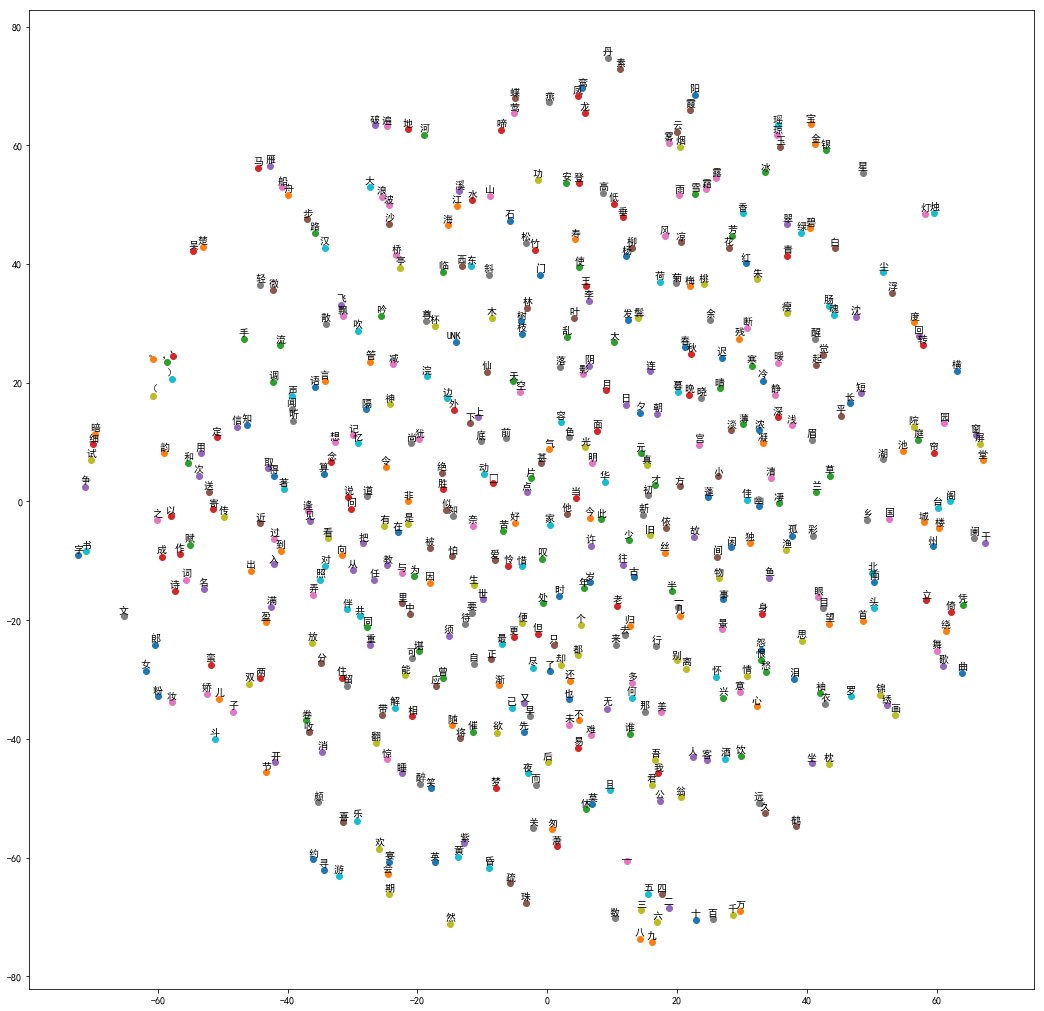

In [11]:
# Step 6: Visualize the embeddings.


# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt
  #设置matplotlib输出中文
  plt.rcParams["font.sans-serif"] = ["SimHei"]
  plt.rcParams['axes.unicode_minus'] = False
  #tsne 通过pca将数据降成二维 方便在图形中显示
  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(os.getcwd(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

### step7  通过json方式保存dictionary和reversed_dictionary

In [12]:
import json

#将计算得到的enmbeding 权重参数保存
np.save('embedding.npy', final_embeddings)

f_dic = open('dictionary.json','w')
f_dic.write(json.dumps(dictionary))

f_redic=open('reversed_dictionary.json','w')
f_redic.write(json.dumps(reverse_dictionary))

88692